<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Experiment/ResNet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git -q
!pip install pytorch-lightning -q
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git -q

     |████████████████████████████████| 808kB 27.3MB/s 
     |████████████████████████████████| 829kB 33.5MB/s 
     |████████████████████████████████| 276kB 35.7MB/s 
     |████████████████████████████████| 645kB 50.8MB/s 
     |████████████████████████████████| 112kB 54.3MB/s 
     |████████████████████████████████| 1.3MB 47.3MB/s 
     |████████████████████████████████| 296kB 49.9MB/s 
     |████████████████████████████████| 143kB 57.8MB/s 


In [3]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset/Train.7z
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset/Val.7z
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset/Test.7z
!7z x "*.7z"

--2021-05-14 09:00:59--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset/Train.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9941071 (9.5M) [application/octet-stream]
Saving to: ‘Train.7z’

Train.7z            100%[===================>]   9.48M  --.-KB/s    in 0.09s   

2021-05-14 09:01:00 (106 MB/s) - ‘Train.7z’ saved [9941071/9941071]

--2021-05-14 09:01:00--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset/Val.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366781 (358K) [applicat

In [4]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import cv2

# Init

In [5]:
train = pd.read_csv('/content/train/train.csv')
val = pd.read_csv('/content/val/val.csv')
test = pd.read_csv('/content/test/test.csv')

In [6]:
label_encoders = dict()
labels = ["phylum","class","species","form","sample"]
for x in labels:
  le = LabelEncoder()
  train[f'{x}_label'] = le.fit_transform(train[x])
  val[f'{x}_label'] = le.transform(val[x])
  test[f'{x}_label'] = le.transform(test[x])
  label_encoders[x] = le

In [7]:
train_transformer = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

val_transformer = transforms.Compose([
        transforms.Resize((256,256)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

## Attribute Dataset

In [8]:
class AttributeDataset(Dataset):
  def __init__(self,csv_file,transform,attribute):
    super().__init__()
    csv = csv_file[[f'{attribute}_label','img_path']]
    self.labels = csv[f'{attribute}_label'].values

    self.images = csv['img_path'].values
    self.transform = transform

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return {'images':img, 'labels':label}

## Uni-Model

In [9]:
class ResNet152(pl.LightningModule):
  def __init__(
      self,
      num_classes_classifier,
      train_weights,
      val_weights,
      train_dataset,
      val_dataset,
      sampling_rate):
    super().__init__()
    self.tr = sampling_rate[0]
    self.vr = sampling_rate[1]
    self.tw = train_weights
    self.vw = val_weights

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset

    self.loss_fn = nn.CrossEntropyLoss()

    self.img_transformer = timm.models.tv_resnet152(pretrained=True,num_classes = 0)
    for params in self.img_transformer.parameters():
      params.requires_grad = False

    self.img_transformer.fc = nn.Linear(2048,num_classes_classifier)

    
  def forward(self,img):  
    return self.img_transformer(img)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(
        self.train_dataset,
        batch_size=32,
        sampler=torch.utils.data.WeightedRandomSampler(self.tw,num_samples=self.tr),
        num_workers = os.cpu_count()
        )

  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        self.val_dataset,
        batch_size = 32,
        sampler = torch.utils.data.WeightedRandomSampler(self.vw,num_samples=self.vr),
        num_workers = os.cpu_count()
        )
    
  def training_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    # self.log("loss",loss,prog_bar=True)
    self.log("accuracy",acc,prog_bar=True)
    return {"loss": loss,'accuracy':acc}

  def validation_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    return {"val_loss": loss.item(),'val_accuracy':acc.item()}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.tensor(
            [output["val_loss"] 
            for output in outputs]
            ).mean()
    avg_acc = torch.tensor(
            [output["val_accuracy"] 
            for output in outputs]
            ).mean()
    
    self.log("val_loss",avg_loss,prog_bar=True)
    self.log("val_accuracy",avg_acc,prog_bar=True)

  def configure_optimizers(self):
    optimizer = [torch.optim.AdamW(
            self.parameters(), 
            lr=1e-4
        )]
    return optimizer

## Multi-attribute dataset

In [10]:
class MultiDataset(Dataset):
  def __init__(self,dataFrame,label_encoders,transform=None):
    self.data = dataFrame
    self.transform = transform
    self.labels = ["phylum_label","class_label","species_label","form_label","sample_label"]
    # self.labels = ["species_label"]
    self.label_encoder = label_encoders
    self.nclasses = self.get_nclasses()

    # self.weights = {k:v/total for k,v in self.nclasses.items()}

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_path = self.data.loc[idx,"img_path"]
    image = Image.open(img_path)
    image = self.transform(image)
    labels = self.data.loc[idx,self.labels].to_dict()
    for label in labels:
      labels[label] = torch.tensor(labels[label],dtype = torch.long)
            
    dict_data = {
    'images': image,
    'labels': labels
    }
    return dict_data

  def get_nclasses(self):
    return self.data[self.labels].nunique().to_dict()

## Multi-label classifier

# Multi Label Classification

In [11]:
class MultiResNet152(pl.LightningModule):
  
  def __init__(
      self,
      train_dataset,
      val_dataset,
      train_img = True
      ):
    super().__init__()
    nclasses = train_dataset.nclasses
    labels = train_dataset.labels
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset


    self.img_transformer = timm.models.tv_resnet152(pretrained=True,num_classes = 0)
    for param in self.img_transformer.parameters():
      param.requires_grad = train_img
    
    self.transformer = nn.TransformerEncoderLayer(d_model=512, nhead=8, dropout = 0.25)
    
    # self.norm = nn.LayerNorm(512, eps=1e-06)

    self.classifiers = nn.ModuleDict()
    self.loss_fn = nn.ModuleDict()
    self.embed = nn.ModuleList()

    for label in labels:
      self.classifiers[label] = nn.Linear(512,nclasses[label])
      self.loss_fn[label] = nn.CrossEntropyLoss()
      self.embed.append(nn.Sequential(nn.Linear(2048,512),
                                      nn.ReLU(),
                                      nn.Dropout(0.25))
                        )
      
  def forward(self,img):  
    repr = self.img_transformer(img)
    repr = torch.cat([self.embed[i](repr).unsqueeze(dim=1) for i in range(len(self.embed))],dim = 1)
    repr = self.transformer(repr)
    y=dict()
    for label,x in zip(self.classifiers.keys(),repr.split(1,dim=1)):
        x = x.squeeze(dim=1)
        # x = self.norm(x)
        y[label]=self.classifiers[label](x)
    return y


  def train_dataloader(self):
    return torch.utils.data.DataLoader(
        self.train_dataset,
        batch_size=32,
        # sampler=torch.utils.data.WeightedRandomSampler(self.tw,num_samples=self.tr),
        num_workers = os.cpu_count()
        )

  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        self.val_dataset,
        batch_size = 32,
        # sampler = torch.utils.data.WeightedRandomSampler(self.vw,num_samples=self.vr),
        num_workers = os.cpu_count()
        )
    
  def get_loss(self,out,labels):
    loss=0
    for label in labels:
        loss+=self.loss_fn[label](out[label],labels[label])
    return loss

  def cal_accuracy(self,out,labels):
    acc = dict()
    for key in out:
        q=(out[key].argmax(axis=1)==labels[key]).sum()/labels[key].size(0)
        acc[key] = q
    return acc

  def training_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.get_loss(outputs,labels)
    acc = self.cal_accuracy(outputs,labels)
    
    # self.log("loss",loss,prog_bar=True)
    # self.log("accuracy",acc,prog_bar=True)
    return {"loss": loss,
            'phylum_accuracy':acc["phylum_label"],
            'class_accuracy':acc["class_label"],
            'form_accuracy':acc["form_label"],
            'sample_accuracy':acc["sample_label"],
            'species_accuracy':acc["species_label"]}

  def validation_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.get_loss(outputs,labels)
    acc = self.cal_accuracy(outputs,labels)
    return {"val_loss": loss.item(),
            'phylum_val_accuracy':acc["phylum_label"],
            'class_val_accuracy':acc["class_label"],
            'form_val_accuracy':acc["form_label"],
            'sample_val_accuracy':acc["sample_label"],
            'species_val_accuracy':acc["species_label"]}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.tensor(
            [output["val_loss"] 
            for output in outputs]
            ).mean()
    phylum_avg_acc = torch.tensor(
            [output["phylum_val_accuracy"] 
            for output in outputs]
            ).mean()
    class_avg_acc = torch.tensor(
            [output["class_val_accuracy"] 
            for output in outputs]
            ).mean()
    sample_avg_acc = torch.tensor(
            [output["sample_val_accuracy"] 
            for output in outputs]
            ).mean()
    form_avg_acc = torch.tensor(
            [output["form_val_accuracy"] 
            for output in outputs]
            ).mean()
    species_avg_acc = torch.tensor(
            [output["species_val_accuracy"] 
            for output in outputs]
            ).mean()
    avg_acc = torch.mean(torch.tensor((species_avg_acc,form_avg_acc,sample_avg_acc,class_avg_acc,phylum_avg_acc)))
    
    self.log("val_loss",avg_loss,prog_bar=True)
    self.log("val_acc",avg_acc,prog_bar=True)
    self.log("species_accuracy",species_avg_acc,prog_bar=True)
    self.log("form_accuracy",form_avg_acc,prog_bar=True)
    self.log("sample_accuracy",sample_avg_acc,prog_bar=True)
    self.log("class_accuracy",class_avg_acc,prog_bar=True)
    self.log("phylum_accuracy",phylum_avg_acc,prog_bar=True)

  def configure_optimizers(self):
    optimizer = [torch.optim.AdamW(
            self.parameters(), 
            lr=1e-4
        )]
    return optimizer

In [12]:
train_dataset = MultiDataset(train,label_encoders,train_transformer)
val_dataset = MultiDataset(val,label_encoders,val_transformer)
test_dataset = MultiDataset(test,label_encoders,val_transformer)

### Finetuning

In [13]:
model = MultiResNet152(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    train_img = True
    )

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [14]:
early_stop_callback = EarlyStopping(
   monitor='val_acc',
   min_delta=0.00,
   patience=10,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='val_acc',
    dirpath='./',
    filename='resnet152-{val_loss:.2f}-{val_acc:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=500,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                    | Params
------------------------------------------------------------
0 | img_transformer | ResNet                  | 58.1 M
1 | transformer     | TransformerEncoderLayer | 3.2 M 
2 | classifiers     | ModuleDict              | 19.5 K
3 | loss_fn         | ModuleDict              | 0     
4 | embed           | ModuleList              | 5.2 M 
------------------------------------------------------------
66.6 M    Trainable params
0         Non-trainable params
66.6 M    Total params
266.245   Total estimated model params size (MB)


### Training

In [ ]:
model = MultiResNet152(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    train_img = False
    )

In [ ]:
early_stop_callback = EarlyStopping(
   monitor='species_accuracy',
   min_delta=0.00,
   patience=6,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='species_accuracy',
    dirpath='./',
    filename='resnet152-trained-{species_accuracy:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=120,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                    | Params
------------------------------------------------------------
0 | img_transformer | ResNet                  | 58.1 M
1 | transformer     | TransformerEncoderLayer | 3.2 M 
2 | classifiers     | ModuleDict              | 19.5 K
3 | loss_fn         | ModuleDict              | 0     
4 | embed           | ModuleList              | 5.2 M 
------------------------------------------------------------
8.4 M     Trainable params
58.1 M    Non-trainable params
66.6 M    Total params
266.245   Total estimated model params size (MB)


## Accuracy

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

test_dataset = MultiDataset(test,label_encoders,val_transformer)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=39)

model = MultiResNet152.load_from_checkpoint("/content/resnet152-val_loss=4.80-species_accuracy=0.74.ckpt",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    train_img = False
    )
model.cuda()
model.eval()
preds = []
true = []
with torch.no_grad():
  for batch in test_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    true.append(labels)
    prediction = model(images)
    preds.append(prediction)

y_pred = {'phylum_label':[], 'class_label':[], 'species_label':[], 'form_label':[], 'sample_label':[]}
y_true = {'phylum_label':[], 'class_label':[], 'species_label':[], 'form_label':[], 'sample_label':[]}

for i in range(len(preds)):
  for key in y_pred:
    y_pred[key].extend(preds[i][key].argmax(axis = 1).cpu().tolist())
    y_true[key].extend(true[i][key].tolist())
    
y = '_label'
for label in y_pred:
  label_le = label.replace(y,'')
  classes = label_encoders[label_le].inverse_transform(np.unique(y_true[label]))
  print(f"\nClassification Report for {label}:\n")
  print(classification_report(y_true[label],y_pred[label],target_names=classes))
  print('='*95)


Classification Report for phylum_label:

                   precision    recall  f1-score   support

        Amoebozoa       1.00      0.33      0.50         3
      Apicomplexa       0.92      1.00      0.96        22
         Nematoda       0.83      0.83      0.83         6
  Platyhelminthes       1.00      1.00      1.00         4
Sarcomastigophora       1.00      1.00      1.00         4

         accuracy                           0.92        39
        macro avg       0.95      0.83      0.86        39
     weighted avg       0.93      0.92      0.91        39


Classification Report for class_label:

               precision    recall  f1-score   support

 Aconoidasida       1.00      1.00      1.00        15
      Cestoda       0.80      1.00      0.89         4
  Chromadorea       0.67      0.50      0.57         4
  Conoidasida       0.88      1.00      0.93         7
      Enoplea       0.33      0.50      0.40         2
    Tubulinea       1.00      0.33      0.50        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Class

In [ ]:

le = LabelEncoder()

train['class_label'] = le.fit_transform(train['class'])
val['class_label'] = le.transform(val['class'])

In [16]:

class_counts = train['class_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['class_label'].values])

train_dataset = AttributeDataset(train,train_transformer,'class')

class_counts = val['class_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['class_label'].values])

val_dataset = AttributeDataset(val,val_transformer,'class')

In [17]:
model = ResNet152(
    num_classes_classifier=7,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    sampling_rate = [3360,1155]
    )

In [18]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=5,
   verbose=False,
   mode='min'
)

model_ckpt = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./',
    filename='class-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='min')

trainer = pl.Trainer(gpus=1,max_epochs=120,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss_fn         | CrossEntropyLoss | 0     
1 | img_transformer | ResNet           | 58.2 M
-----------------------------------------------------
14.3 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.633   Total estimated model params size (MB)


### Accuracy

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

test_dataset = AttributeDataset(test,val_transformer,'class')
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=39)

model = ResNet152.load_from_checkpoint("/content/class-val_loss=0.78-val_accuracy=0.75.ckpt",num_classes_classifier=7,
    train_weights=None,
    val_weights=None,
    train_dataset=None,
    val_dataset=None,
    sampling_rate = [0,0]
    )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in test_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=label_encoders['class'].classes_))

               precision    recall  f1-score   support

 Aconoidasida       1.00      0.80      0.89        15
      Cestoda       0.80      1.00      0.89         4
  Chromadorea       0.67      0.50      0.57         4
  Conoidasida       0.67      0.86      0.75         7
      Enoplea       0.50      1.00      0.67         2
    Tubulinea       1.00      0.33      0.50         3
Zooflagellate       0.60      0.75      0.67         4

     accuracy                           0.77        39
    macro avg       0.75      0.75      0.70        39
 weighted avg       0.82      0.77      0.77        39



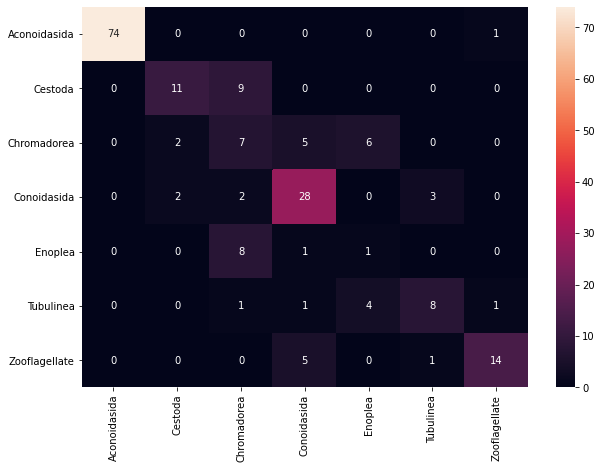

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = label_encoders['class'].classes_,
                  columns = label_encoders['class'].classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
!unzip -q /content/GradCAM.zip

### GradCam

In [ ]:
model = ResNet152.load_from_checkpoint("/content/class-val_loss=0.87-val_accuracy=0.67.ckpt",num_classes_classifier=7,
    train_weights=None,
    val_weights=None,
    train_dataset=None,
    val_dataset=None,
    sampling_rate = [0,0]
    )

In [ ]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git -q
!pip install ttach -q

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

target_layer = model.img_transformer
cam = GradCAMPlusPlus(model=model, 
                      target_layer=target_layer)

def plot_get(img_path,class_idx):
  rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
  rgb_img = cv2.resize(rgb_img, (256, 256))
  rgb_img = np.float32(rgb_img) / 255
  input_tensor = preprocess_image(rgb_img, mean=(0.485, 0.456, 0.406), 
                                          std=(0.229, 0.224, 0.225)).cuda()
  grayscale_cam = cam(input_tensor=input_tensor,
                    target_category=class_idx,
                    eigen_smooth=True,
                    aug_smooth=True)

  grayscale_cam = grayscale_cam[0, :]
  img_path = img_path.split('/')
  save_path = '/'.join(img_path[:6])+'/'+img_path[4]+'='+img_path[6]    
  cam_image = show_cam_on_image(rgb_img, grayscale_cam)
  cv2.imwrite(save_path, cam_image)
  torch.cuda.empty_cache()
  return Image.fromarray(cam_image)

In [ ]:
plot_get("/content/GradCAM/Class/Aconoidasida/Falciparium/Pf_gametocyte_thinF_0_27.jpg",None)

IndexError: ignored

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


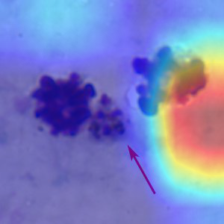

In [ ]:
plot_get("/content/EffNet-B0/Class/Aconoidasida/Ovale/Po_gametocyte_thickB_0_285.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


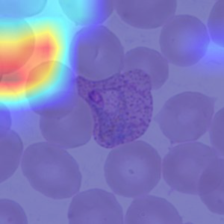

In [ ]:
plot_get("/content/EffNet-B0/Class/Aconoidasida/Vivax/Pv_troph_thinC_0_312.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


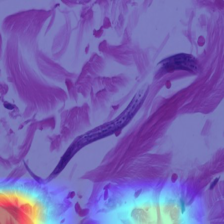

In [ ]:
plot_get("/content/EffNet-B0/Class/Chromadorea/Stercoralis/S_stercoralis_intbiopsy_400x_BAM1_0_367.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


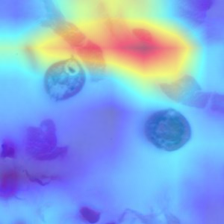

In [ ]:
plot_get("/content/EffNet-B0/Class/Chromadorea/Stercoralis1K/S_stercoralis_intbiopsy_1000x_BAM1_0_366.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


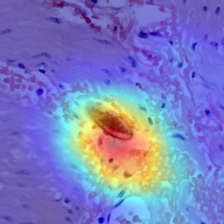

In [ ]:
plot_get("/content/EffNet-B0/Class/Chromadorea/vermicularis/E_vermicularis_eggs_tissue2_0_157.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


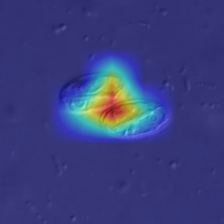

In [ ]:
plot_get("/content/EffNet-B0/Class/Zooflagellate/Giardia_cyst_dic/Giardia_cyst_dic2_0_165.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


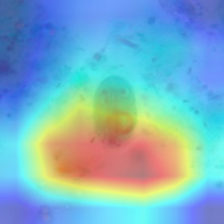

In [ ]:
plot_get("/content/EffNet-B0/Class/Zooflagellate/Giardia_cyst_tric/Giardia_cyst_tric4_0_174.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


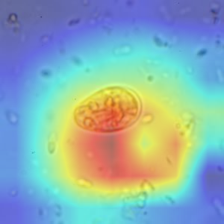

In [ ]:
plot_get("/content/EffNet-B0/Class/Zooflagellate/Giardia_cyst_wtmt/Giardia_cyst_wtmt4_0_163.jpg")

In [ ]:
!zip -rq EffNet-B0.zip EffNet-B0

# Phylum

In [ ]:

le = LabelEncoder()

train['phylum_label'] = le.fit_transform(train['phylum'])
val['phylum_label'] = le.transform(val['phylum'])

In [20]:

class_counts = train['phylum_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['phylum_label'].values])

train_dataset = AttributeDataset(train, train_transformer,'phylum')

class_counts = val['phylum_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['phylum_label'].values])

val_dataset = AttributeDataset(val, val_transformer,'phylum')

In [21]:
model = ResNet152(
    num_classes_classifier=5,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    sampling_rate = [3550,1225]
    )

In [22]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=5,
   verbose=False,
   mode='min'
)

model_ckpt = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./',
    filename='phylum-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='min')

trainer = pl.Trainer(gpus=1,max_epochs=120,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss_fn         | CrossEntropyLoss | 0     
1 | img_transformer | ResNet           | 58.2 M
-----------------------------------------------------
10.2 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.616   Total estimated model params size (MB)


### Accuracy

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

test_dataset = AttributeDataset(test, val_transformer,'phylum')
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=39)

model = ResNet152.load_from_checkpoint("/content/phylum-val_loss=0.34-val_accuracy=0.83.ckpt",
                                        num_classes_classifier=5,
                                        train_weights=None,
                                        val_weights=None,
                                        train_dataset=None,
                                        val_dataset=None,
                                        sampling_rate = [0,0]
                                        )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in test_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=label_encoders['phylum'].classes_))

                   precision    recall  f1-score   support

        Amoebozoa       1.00      0.33      0.50         3
      Apicomplexa       0.95      0.91      0.93        22
         Nematoda       0.50      0.50      0.50         6
  Platyhelminthes       0.67      1.00      0.80         4
Sarcomastigophora       0.60      0.75      0.67         4

         accuracy                           0.79        39
        macro avg       0.74      0.70      0.68        39
     weighted avg       0.82      0.79      0.79        39



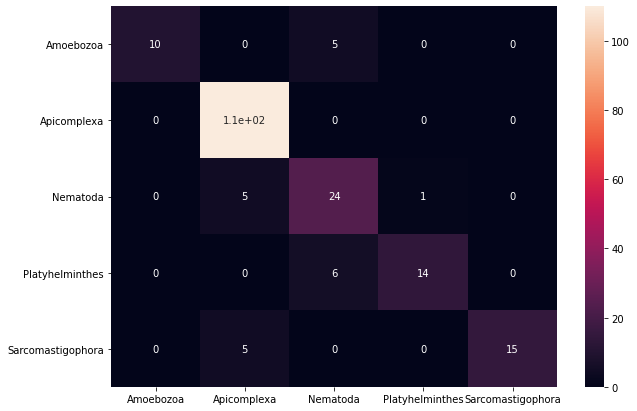

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = label_encoders['phylum'].classes_,
                  columns = label_encoders['phylum'].classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
!unzip /content/ResNet200D.zip

### GradCam

In [ ]:
# from utils import *
# from visualisation.core.utils import device 
# from visualisation.core.utils import image_net_postprocessing
# from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
# from visualisation.core import *
# from visualisation.core.utils import image_net_preprocessing

# test_transform = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.ToTensor(),
#                                      image_net_preprocessing])

vis = GradCam(model, device)

In [ ]:
def plot_get(img_path):
  img = test_transform(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
  arr = tensor2img(vis(img, None,postprocessing=image_net_postprocessing)[0])
  arr = (arr*255).astype(np.uint8)
  img_path = img_path.split('/')
  save_path = '/'.join(img_path[:6]) + '/' + img_path[4] + '=' + img_path[6]
  Image.fromarray(arr).save(save_path)
  torch.cuda.empty_cache()
  return Image.fromarray(arr)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


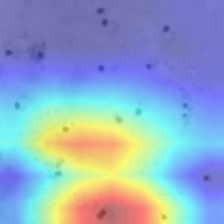

In [ ]:
plot_get("/content/EffNet-B0/Phylum/Apicomplexa/Pf_rings_thick/Pf_rings_thickC_3_214.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


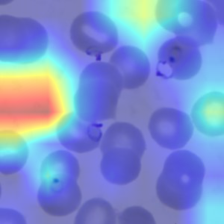

In [ ]:
plot_get("/content/EffNet-B0/Phylum/Apicomplexa/Pf_rings_thin/Pf_rings_thinE_0_213.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


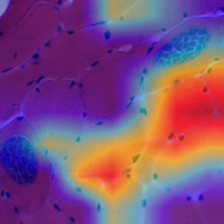

In [ ]:
plot_get("/content/EffNet-B0/Phylum/Apicomplexa/Sarcocystis/Sarcocystis_muscle_HE_MI_2_rotated_0_345.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


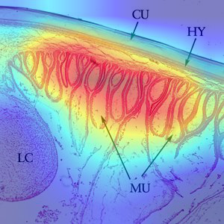

In [ ]:
plot_get("/content/EffNet-B0/Phylum/Nematoda/Ascaris cuticle/Ascaris_cuticle_cross_section_0_40.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


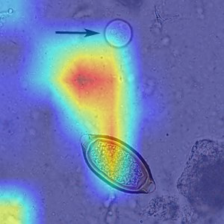

In [ ]:
plot_get("/content/EffNet-B0/Phylum/Nematoda/Trichuris and Ecoli/Trichuris_and_Ecoli_HB_0_371.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


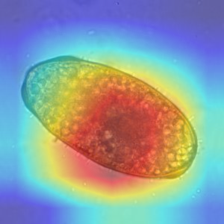

In [ ]:
plot_get("/content/EffNet-B0/Phylum/Nematoda/lumbricoides/A_lumbricoides_infert_Leiden_B_0_22.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


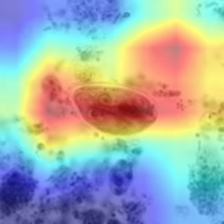

In [ ]:
plot_get("/content/EffNet-B0/Phylum/Sarcomastigophora/Giardia cyst/Giardia_cyst_tric2_3_169.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


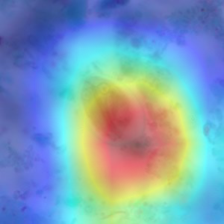

In [ ]:
plot_get("/content/EffNet-B0/Phylum/Sarcomastigophora/Giardia cyst-2/Giardia_cyst_tric10_0_171.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


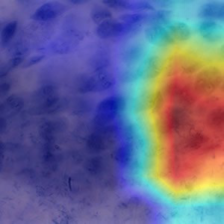

In [ ]:
plot_get("/content/EffNet-B0/Phylum/Sarcomastigophora/Giardia troph/Giardia_troph_VT_0_181.jpg")

In [ ]:
!pwd

/content


In [ ]:
!zip -r EffNet-B0.zip EffNet-B0

# Species

In [ ]:

le = LabelEncoder()

train['species_label'] = le.fit_transform(train['species'])
val['species_label'] = le.transform(val['species'])

In [26]:

class_counts = train['species_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['species_label'].values])

train_dataset = AttributeDataset(train, train_transformer,'species')

class_counts = val['species_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['species_label'].values])

val_dataset = AttributeDataset(val, val_transformer,'species')

In [27]:
len(label_encoders['species'].classes_)

15

In [ ]:
torch.cuda.empty_cache()

In [28]:

model = ResNet152(
    num_classes_classifier=15,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    sampling_rate = [2160,720]
    )

In [29]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=5,
   verbose=False,
   mode='min'
)

model_ckpt = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./',
    filename='species-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='min')

trainer = pl.Trainer(gpus=1,max_epochs=120,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss_fn         | CrossEntropyLoss | 0     
1 | img_transformer | ResNet           | 58.2 M
-----------------------------------------------------
30.7 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.698   Total estimated model params size (MB)


### Accuracy

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

test_dataset = AttributeDataset(test, val_transformer,'species')
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=51)

model = ResNet152.load_from_checkpoint("/content/species-val_loss=0.90-val_accuracy=0.73.ckpt",
                                        num_classes_classifier=15,
                                        train_weights=None,
                                        val_weights=None,
                                        train_dataset=None,
                                        val_dataset=None,
                                        sampling_rate = [0,0]
                                        )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in test_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=label_encoders['species'].classes_))

                         precision    recall  f1-score   support

   Ascaris lumbricoides       1.00      1.00      1.00         2
    Cryptosporidium sp.       0.67      1.00      0.80         2
Cyclospora cayetanensis       0.75      0.75      0.75         4
Dibothriocephalus latus       0.00      0.00      0.00         1
  Entamoeba histolytica       1.00      0.67      0.80         3
Enterobius vermicularis       0.00      0.00      0.00         2
     Giardia duodenalis       0.50      0.50      0.50         4
        Hymenolepis spp       1.00      0.67      0.80         3
  Plasmodium falciparum       0.50      0.25      0.33         4
    Plasmodium knowlesi       0.33      1.00      0.50         1
    Plasmodium malariae       0.40      0.67      0.50         3
       Plasmodium ovale       0.00      0.00      0.00         3
       Plasmodium vivax       0.00      0.00      0.00         4
        Sarcocystis sp.       0.50      1.00      0.67         1
    Trichuris Trichuria 

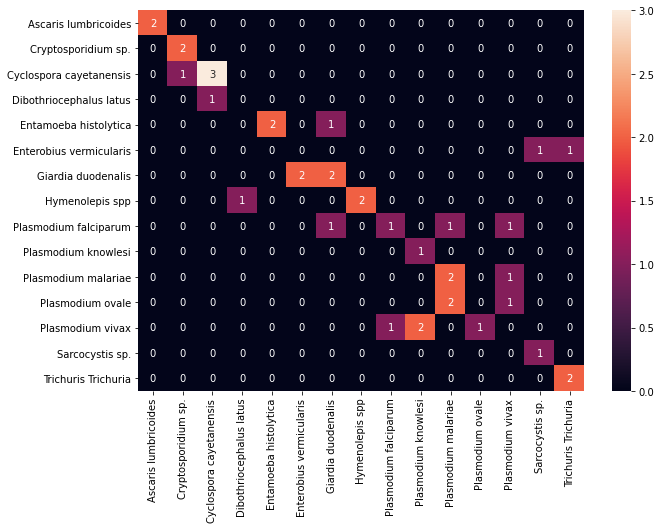

In [31]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = label_encoders['species'].classes_,
                  columns = label_encoders['species'].classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

### GradCam

In [ ]:
%cd /content/A-journey-into-Convolutional-Neural-Network-visualization-

In [ ]:
# from utils import *
# from visualisation.core.utils import device 
# from visualisation.core.utils import image_net_postprocessing
# from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
# from visualisation.core import *
# from visualisation.core.utils import image_net_preprocessing

# test_transform = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.ToTensor(),
#                                      image_net_preprocessing])

vis = GradCam(model, device)

In [ ]:
def plot_get(img_path):
  img = test_transform(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
  arr = tensor2img(vis(img, None,postprocessing=image_net_postprocessing)[0])
  arr = (arr*255).astype(np.uint8)
  img_path = img_path.split('/')
  save_path = '/'.join(img_path[:6]) + '/' + img_path[4] + '=' + img_path[6]
  Image.fromarray(arr).save(save_path)
  torch.cuda.empty_cache()
  return Image.fromarray(arr)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


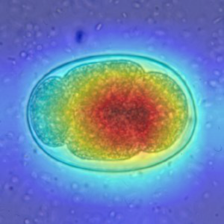

In [ ]:
plot_get("/content/EffNet-B0/Species/Ancyclostoma/Hookworm/Hookworm_2x2_B_0_3.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


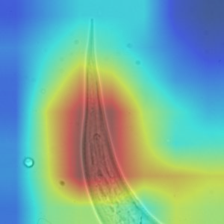

In [ ]:
plot_get("/content/EffNet-B0/Species/Ancyclostoma/Hookworm_filariform/Hookworm_filariform_posterior_A_0_11.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


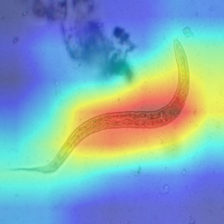

In [ ]:
plot_get("/content/EffNet-B0/Species/Ancyclostoma/Hookworm_rhabditiform/Hookworm_rhabditiform_2_0_7.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


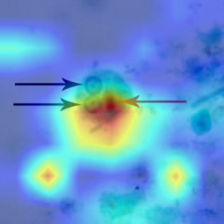

In [ ]:
plot_get("/content/EffNet-B0/Species/Entamoeba/Ehistdisp cyst/Ehistdisp_cyst_tric3_0_120.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


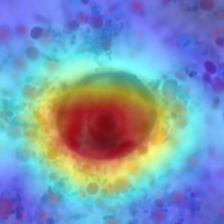

In [ ]:
plot_get("/content/EffNet-B0/Species/Entamoeba/Ehistdisp cyst tric/Ehistdisp_cyst_tric6_KS_0_123.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


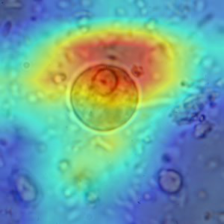

In [ ]:
plot_get("/content/EffNet-B0/Species/Entamoeba/Ehistdisp cyst wtmt/Ehistdisp_cyst_wtmt_0_115.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


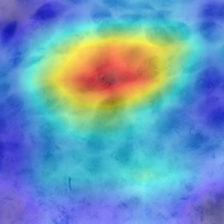

In [ ]:
plot_get("/content/EffNet-B0/Species/Giardia duodenalis/Giardia troph/Giardia_troph_VT_0_181.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


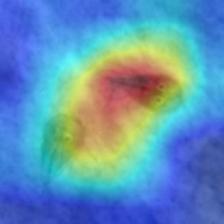

In [ ]:
plot_get("/content/EffNet-B0/Species/Giardia duodenalis/Giardia troph kohn/Giardia_troph_kohn_0_182.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


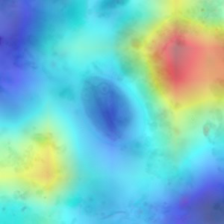

In [ ]:
plot_get("/content/EffNet-B0/Species/Giardia duodenalis/Giardia_cyst_tric/Giardia_cyst_tric10_0_171.jpg")

In [ ]:
!zip -r EffNet-B0.zip EffNet-B0

  adding: EffNet-B0/ (stored 0%)
  adding: EffNet-B0/Phylum/ (stored 0%)
  adding: EffNet-B0/Phylum/Apicomplexa/ (stored 0%)
  adding: EffNet-B0/Phylum/Apicomplexa/Pf_rings_thin/ (stored 0%)
  adding: EffNet-B0/Phylum/Apicomplexa/Pf_rings_thin/Apicomplexa=Pf_rings_thinE_0_213.jpg (deflated 3%)
  adding: EffNet-B0/Phylum/Apicomplexa/Pf_rings_thin/Pf_rings_thinE_0_213.jpg (deflated 2%)
  adding: EffNet-B0/Phylum/Apicomplexa/Sarcocystis/ (stored 0%)
  adding: EffNet-B0/Phylum/Apicomplexa/Sarcocystis/Apicomplexa=Sarcocystis_muscle_HE_MI_2_rotated_0_345.jpg (deflated 2%)
  adding: EffNet-B0/Phylum/Apicomplexa/Sarcocystis/Sarcocystis_muscle_HE_MI_2_rotated_0_345.jpg (deflated 1%)
  adding: EffNet-B0/Phylum/Apicomplexa/Pf_rings_thick/ (stored 0%)
  adding: EffNet-B0/Phylum/Apicomplexa/Pf_rings_thick/Apicomplexa=Pf_rings_thickC_3_214.jpg (deflated 3%)
  adding: EffNet-B0/Phylum/Apicomplexa/Pf_rings_thick/Pf_rings_thickC_3_214.jpg (deflated 4%)
  adding: EffNet-B0/Phylum/Nematoda/ (stored 0%)
 